In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

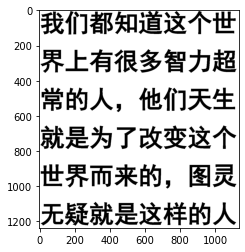

In [ ]:
text=cv2.imread('/content/drive/MyDrive/chinese.png')
text=cv2.cvtColor(text,cv2.COLOR_BGR2GRAY)
plt.imshow(text,cmap='gray')

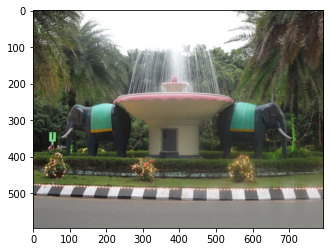

In [ ]:
img=cv2.imread('/content/drive/MyDrive/Gajendra_circle.jpeg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
text_idx=cv2.resize(text,img.shape[:2]).T
text_mask=text_idx==255
text_mask=text_mask.astype(np.double)
text_D=np.zeros_like(img).astype(np.double)

In [ ]:
text_mask_c=np.ones_like(text_mask)-text_mask

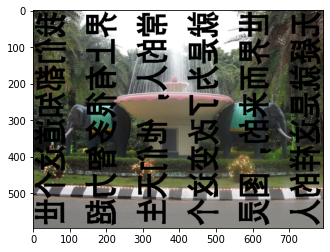

In [ ]:
for i in range(3):
  text_D[:,:,i]=np.multiply(text_mask,img[:,:,i])
text_D/=255
plt.imshow(text_D)

In [ ]:
U=[]
Sigma=[]
V=[]
for i in range(3):
  u,sigma,v=np.linalg.svd(img[:,:,i])
  U.append(u)
  Sigma.append(sigma)
  V.append(v)

In [ ]:
trunc_rank=50
img_trunc=np.zeros(img.shape)
m=img.shape[0]
n=img.shape[1]
for i in range(3):
  trunc_U=U[i][:,:trunc_rank]
  trunc_V=V[i][:trunc_rank,:]
  trunc_Sigma=Sigma[i][:trunc_rank]
  Sigma_matrix=np.zeros((trunc_rank,trunc_rank))
  np.fill_diagonal(Sigma_matrix,trunc_Sigma)   #works inplace
  img_trunc[:,:,i]=trunc_U@Sigma_matrix@trunc_V


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


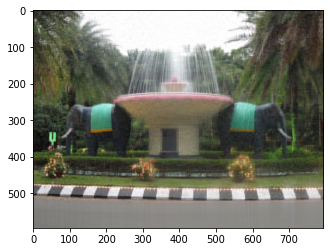

In [ ]:
plt.imshow(img_trunc/255)

In [ ]:
mask_r=0.75 # random mask rate
rand=100*np.random.rand(m,n)
rand_idx=rand<100*(1-mask_r)
rand_mask=rand_idx.astype(np.double)
rand_mask_c=np.ones_like(rand_idx)-rand_mask

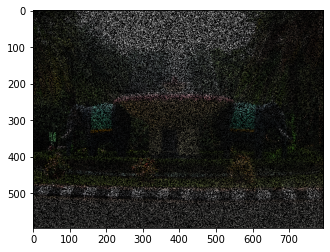

In [ ]:
rand_D=np.zeros(img.shape).astype(np.double)
for i in range(3):
  rand_D[:,:,i]=np.multiply(img[:,:,i],rand_mask)
rand_D/=255
plt.imshow(rand_D)

In [ ]:
D_omega=rand_D  #choosing random or text masks
omega=rand_mask
omega_c=rand_mask_c

In [ ]:
iter=100
lamda=1
tau=25
p=0.9
rho=1.5
mu=1.5
iter_des=100

In [ ]:
def update_X(E_omega,Y_omega,W,Z,i):
  K_omega=E_omega+D_omega[:,:,i]+(1/mu)*Y_omega
  N=W-(1/mu)*Z
  X_omega=(K_omega+np.multiply(N,omega))/2
  X_omega_c=np.multiply(N,omega_c)
  X=X_omega + X_omega_c
  return X



In [ ]:
def update_E_omega(X,Y_omega,i):
  X_omega=np.multiply(X,omega)
  H_omega=X_omega-D_omega[:,:,i]-(1/mu)*Y_omega
  E_omega=(2/(mu+2))*H_omega
  return E_omega


In [ ]:
def gradient_descent(sing_val):
  x_k=sing_val
  for i in range(iter_des):
    x_k1=sing_val-lamda*p*(x_k**(p-1))
    x_k=x_k1
  return x_k


In [ ]:
def update_W(X,Z):
  G=X+(1/mu)*Z;
  Q,delta,R=np.linalg.svd(G)
  sigma_w=np.zeros_like(delta).astype(np.double)
  v=(2*lamda*(1-p))**(1/(2-p))
  v1=v+lamda*p*(v**(p-1))
  for i in range(min(m,n)):
    s=delta[i]
    if s>=v1:
      x1=gradient_descent(s)
    else:
      x1=0
    tau1=((1/(2*lamda))*((x1-s)**2)+ x1**p)**(1/p)
    if tau<=tau1:
      sigma_w[i]=s
    else:
      sigma_w[i]=x1
  sigma_star=np.zeros_like(omega).astype(np.double)
  np.fill_diagonal(sigma_star,sigma_w)
  W=Q@sigma_star@R
  return W

In [ ]:
def metrics(X):
  MSE=np.sum(np.square(255*X-img))/(img.shape[0]*img.shape[1]*3)
  PSNR=10*math.log10(255**2/MSE)
  fro_norm=np.sum(np.square(img))
  relative_error=np.sum(np.square(255*X-img))/fro_norm
  return MSE,PSNR,relative_error


In [ ]:
def restore():
  global mu
  img_restored=np.zeros_like(img).astype(np.double)
  mse_his=[]
  psnr_his=[]
  error_his=[]
  update_his=np.zeros((4,3)).astype(np.ndarray)
  for j in range(iter):
      for i in range(3):
        if iter==0:
          Y_omega=D_omega[:,:,i]
          E_omega=D_omega[:,:,i]
          W=D_omega[:,:,i]
          Z=D_omega[:,:,i]
        else:
          Y_omega=update_his[0,i]
          E_omega=update_his[1,i]
          W=update_his[2,i]
          Z=update_his[3,i]
        X=update_X(E_omega,Y_omega,W,Z,i)
        E_omega=update_E_omega(X,Y_omega,i)
        W=update_W(X,Z)
        Y_omega=Y_omega + mu*(E_omega + D_omega[:,:,i] - np.multiply(X,omega))
        Z=Z+ mu*(X - W)
        update_his[0,i]=Y_omega
        update_his[1,i]=E_omega
        update_his[2,i]=W
        update_his[3,i]=Z
        img_restored[:,:,i]=X
      mu*=rho
      mse,psnr,error=metrics(img_restored)
      mse_his.append(mse)
      psnr_his.append(psnr)
      error_his.append(error)
      if j%10==0:
        print(f'psnr: {psnr} mse: {mse} rel_error: {error}')
  plt.figure()
  plt.plot(np.arange(iter),psnr_his,label='psnr')
  plt.plot(np.arange(iter),error_his,label='rel error')
  plt.legend()
  plt.show()
  plt.figure()
  plt.title('Masked Image')
  plt.imshow(D_omega)
  plt.figure()
  plt.title('Restored Image')
  plt.imshow(img_restored)
  plt.figure()
  plt.title('Original Image')
  plt.imshow(img)      

psnr: 9.506888168545581 mse: 7284.362400426166 rel_error: 74.79987379217474
psnr: 13.490971256111127 mse: 2910.6047600118313 rel_error: 29.887704199759604
psnr: 14.59008387290855 mse: 2259.8102468886 rel_error: 23.204985140723
psnr: 15.500762653372247 mse: 1832.3317017418678 rel_error: 18.8153983151187
psnr: 16.26029121237143 mse: 1538.3361280462766 rel_error: 15.796488683906272
psnr: 16.87859008036712 mse: 1334.2012795789822 rel_error: 13.700318825437256
psnr: 17.392089028712377 mse: 1185.4178375702381 rel_error: 12.172527912128452
psnr: 17.826812618091466 mse: 1072.5044407095188 rel_error: 11.013070519655304
psnr: 18.202706818243282 mse: 983.5799768540288 rel_error: 10.099944798035757
psnr: 18.56270506431622 mse: 905.336134106212 rel_error: 9.296493618532514
psnr: 18.886147375577387 mse: 840.3604855199069 rel_error: 8.629287616599392
psnr: 19.20595674003855 mse: 780.7009122956994 rel_error: 8.016670025332287
psnr: 19.546637937664663 mse: 721.7994837445084 rel_error: 7.411837484113565

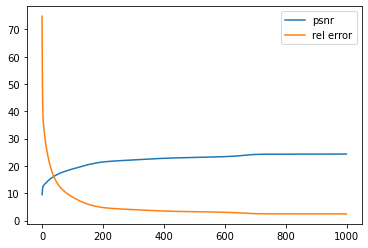

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


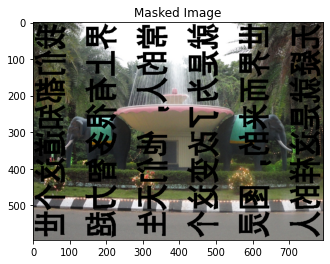

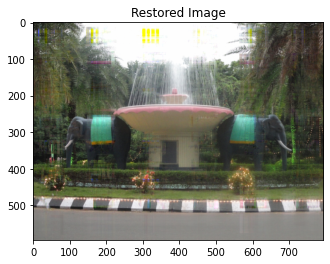

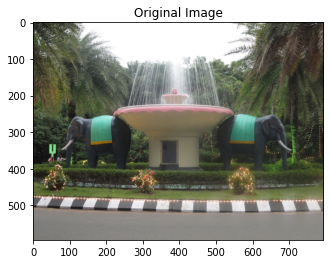

In [ ]:
restore()

psnr: 6.883363861677779 mse: 13327.355262331634 rel_error: 136.85267657023215
psnr: 9.41173699870711 mse: 7445.71932566812 rel_error: 76.45677620588297
psnr: 11.5526364729695 mse: 4547.960808700003 rel_error: 46.70098435555799
psnr: 13.955561790036093 mse: 2615.3160669754157 rel_error: 26.85551610185718
psnr: 16.680953284547723 mse: 1396.320237247196 rel_error: 14.338190740405683
psnr: 19.61429931547759 mse: 710.6412766809759 rel_error: 7.297258824483676
psnr: 22.319535912632503 mse: 381.1770719058225 rel_error: 3.9141376147565325
psnr: 24.072648764228255 mse: 254.5748429068493 rel_error: 2.614115700638534
psnr: 24.74415884451202 mse: 218.10442479318206 rel_error: 2.2396172171624023
psnr: 24.937535168037304 mse: 208.60602327771088 rel_error: 2.142082361600702


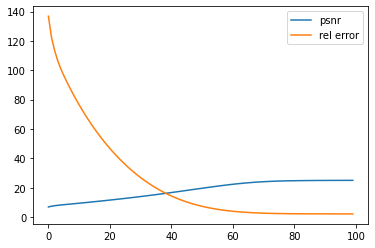

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


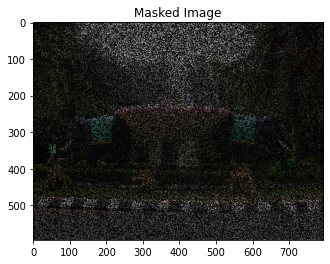

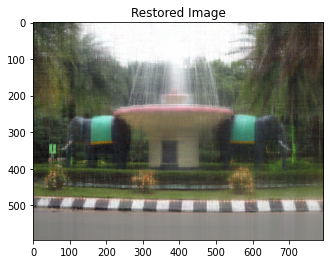

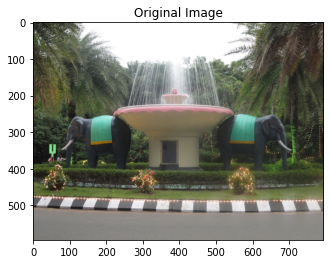

In [ ]:
restore()